In [ ]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Import libraries
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os
import zipfile

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# EXACT path from your screenshot
DATA_DIR = '/content/drive/MyDrive/PlantVillage'

# Image settings (Standard for MobileNetV2)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Setup Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values (0-1)
    rotation_range=25,          # Rotate images slightly
    width_shift_range=0.2,      # Shift width
    height_shift_range=0.2,     # Shift height
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom in/out
    horizontal_flip=True,       # Flip horizontally
    brightness_range=[0.8, 1.2],# Simulate different lighting (Crucial for mobile!)
    fill_mode='nearest',
    validation_split=0.2        # Use 20% of data for checking accuracy
)

# 2. Load Training Data (80%)
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# 3. Load Validation Data (20%)
print("\nLoading Validation Data:")
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# IMPORTANT: Print the class mapping
# You MUST copy this output list for your React Native App
print("\n✅ YOUR CLASS INDICES (Copy these for React Native):")
print(train_generator.class_indices)

Loading Training Data:
Found 6085 images belonging to 5 classes.

Loading Validation Data:
Found 1520 images belonging to 5 classes.

✅ YOUR CLASS INDICES (Copy these for React Native):
{'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Leaf_Mold': 3, 'Tomato_healthy': 4}


In [ ]:
# Load pre-trained MobileNetV2 (without the top "classification" layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (so we don't ruin the pre-learned patterns yet)
base_model.trainable = False

# Add our custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x) # Drops 30% of neurons randomly to prevent overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model built successfully!")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built successfully!


In [ ]:
# 1. Re-compile the model to reset weights and start fresh
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 2. Train with the FIX (using len() to avoid the error)
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),    # <--- The fix is here
    validation_data=validation_generator,
    validation_steps=len(validation_generator), # <--- And here
    epochs=epochs
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.9040 - loss: 0.2647 - val_accuracy: 0.9224 - val_loss: 0.2032
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.9201 - loss: 0.2166 - val_accuracy: 0.9263 - val_loss: 0.1925
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9211 - loss: 0.2120 - val_accuracy: 0.9197 - val_loss: 0.2165
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9309 - loss: 0.2014 - val_accuracy: 0.9303 - val_loss: 0.1784
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9290 - loss: 0.1985 - val_accuracy: 0.9257 - val_loss: 0.2049
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9354 - loss: 0.1826 - val_accuracy: 0.9309 - val_loss: 0.1775
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9419 - loss: 0.1729 - val_accuracy: 0.9289 - val_loss: 0.1644
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9343 - loss: 0.1827 - val_accu

In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a LOW learning rate (important!)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

print("Starting Fine-Tuning...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5, # Train for 5 more epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Starting Fine-Tuning...
Epoch 1/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.6178 - loss: 1.7920 - val_accuracy: 0.9342 - val_loss: 0.1902
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.8438 - loss: 0.4041 - val_accuracy: 0.9455 - val_loss: 0.1594
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.8739 - loss: 0.3739 - val_accuracy: 0.9282 - val_loss: 0.1997
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 389ms/step - accuracy: 0.8750 - loss: 0.3674 - val_accuracy: 0.9355 - val_loss: 0.2076
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.8999 - loss: 0.2906 - val_accuracy: 0.9295 - val_loss: 0.1965


In [ ]:
model.save('tomato_model.h5')

In [ ]:
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
print("Conversion complete! Checking files...")
!ls tfjs_model

Conversion complete! Checking files...
group1-shard1of3.bin  group1-shard2of3.bin  group1-shard3of3.bin  model.json


In [ ]:
from google.colab import files

# 1. Zip the folder (browsers hate downloading 100 small files)
!zip -r tfjs_model.zip tfjs_model

# 2. Trigger the download
files.download('tfjs_model.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preparing data for evaluation...
Found 1520 images belonging to 5 classes.

Calculating Overall Accuracy...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9402 - loss: 0.1933

🌟 Test Accuracy: 94.14%
Generating predictions (this might take a moment)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step


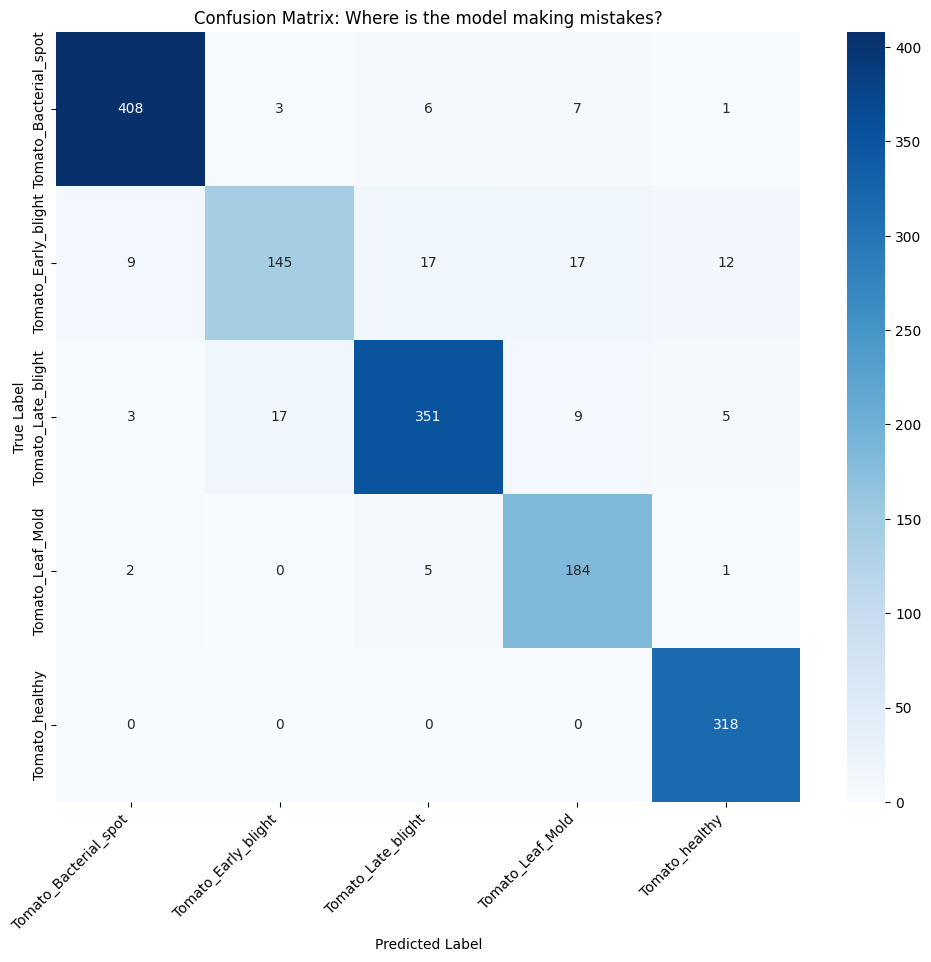


Detailed Classification Report:
                       precision    recall  f1-score   support

Tomato_Bacterial_spot       0.97      0.96      0.96       425
  Tomato_Early_blight       0.88      0.72      0.79       200
   Tomato_Late_blight       0.93      0.91      0.92       385
     Tomato_Leaf_Mold       0.85      0.96      0.90       192
       Tomato_healthy       0.94      1.00      0.97       318

             accuracy                           0.93      1520
            macro avg       0.91      0.91      0.91      1520
         weighted avg       0.93      0.93      0.92      1520



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-load Validation Data (Shuffle=False is CRITICAL for the Confusion Matrix)
print("Preparing data for evaluation...")
eval_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <--- MUST BE FALSE for correct confusion matrix
)

# 2. Get Overall Accuracy
print("\nCalculating Overall Accuracy...")
loss, accuracy = model.evaluate(eval_generator)
print(f"\n🌟 Test Accuracy: {accuracy * 100:.2f}%")

# 3. Generate Predictions
print("Generating predictions (this might take a moment)...")
predictions = model.predict(eval_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = eval_generator.classes
class_labels = list(eval_generator.class_indices.keys())

# 4. Create Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 5. Plot the Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Where is the model making mistakes?')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Detailed Report (Precision/Recall)
print("\nDetailed Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))